In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
#from dnn_app_utils_v3 import *
from sklearn import datasets
from sklearn.model_selection import train_test_split
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import pandas as pd

/home/dan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [3]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) *np.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [4]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [6]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [7]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [8]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [9]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [10]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [12]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [13]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [14]:
# Example 1
# Iris dataset

iris = datasets.load_iris()
x = iris.data
y = ((iris.target != 0) * 1)  # convert the target's dataset into binary

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)

m_train = len(x_train)
m_test = len(x_test)
num_n = x_train.shape[1]
numtest_n = x_test.shape[1]

y_train = y_train.reshape(m_train,1)
y_test = y_test.reshape(m_test,1)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("number of features of each example: num_n = " + str(num_n))
print("shape of x_train:",x_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of x_test:",x_test.shape)
print("shape of y_test:",y_test.shape)

Number of training examples: m_train = 105
Number of testing examples: m_test = 45
number of features of each example: num_n = 4
shape of x_train: (105, 4)
shape of y_train: (105, 1)
shape of x_test: (45, 4)
shape of y_test: (45, 1)


In [15]:
### CONSTANTS ###
layers_dims = [x_train.shape[1], 5, 1] #  4-layer model
print(layers_dims)

[4, 5, 1]


Cost after iteration 0: 0.108542
Cost after iteration 100: 0.103612
Cost after iteration 200: 0.099040
Cost after iteration 300: 0.094785
Cost after iteration 400: 0.090808
Cost after iteration 500: 0.087235
Cost after iteration 600: 0.084187
Cost after iteration 700: 0.081347
Cost after iteration 800: 0.078739
Cost after iteration 900: 0.076282
Cost after iteration 1000: 0.073957
Cost after iteration 1100: 0.071784
Cost after iteration 1200: 0.069751
Cost after iteration 1300: 0.067824
Cost after iteration 1400: 0.066021
Cost after iteration 1500: 0.064299
Cost after iteration 1600: 0.062673
Cost after iteration 1700: 0.061120
Cost after iteration 1800: 0.059636
Cost after iteration 1900: 0.058216
Cost after iteration 2000: 0.056860
Cost after iteration 2100: 0.055592
Cost after iteration 2200: 0.054382
Cost after iteration 2300: 0.053234
Cost after iteration 2400: 0.052148
Cost after iteration 2500: 0.051109
Cost after iteration 2600: 0.050111
Cost after iteration 2700: 0.049162
Cost

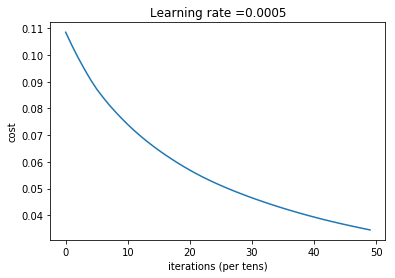

In [16]:
parameters = L_layer_model(x_train.T, y_train.T, layers_dims = layers_dims, learning_rate = 0.0005,num_iterations = 5000, print_cost=True)

In [17]:
predictions_train = predict(x_train.T, y_train.T, parameters)

Accuracy: 0.9999999999999998


In [18]:
predictions_train = predict(x_test.T, y_test.T, parameters)

Accuracy: 1.0000000000000002


In [19]:
# Example 2
# Titanic Dataset

X_train = pd.read_csv('./dataset/X_train.csv')
y_train = pd.read_csv('./dataset/y_train.csv')
X_test = pd.read_csv('./dataset/X_test.csv')

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values

m_train = len(X_train)
m_test = len(X_test)
num_n = x_train.shape[1]
numtest_n = x_test.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("number of features of each example: num_n = " + str(num_n))
print("shape of x_train:",X_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of x_test:",X_test.shape)

Number of training examples: m_train = 890
number of features of each example: num_n = 4
shape of x_train: (890, 17)
shape of y_train: (890, 1)
shape of x_test: (417, 17)


In [20]:
layers_dims = [17, 100, 50, 25, 10, 1]
print(layers_dims)

[17, 100, 50, 25, 10, 1]


Cost after iteration 0: 1.801868
Cost after iteration 100: 0.410970
Cost after iteration 200: 0.386790
Cost after iteration 300: 0.377157
Cost after iteration 400: 0.369899
Cost after iteration 500: 0.363562
Cost after iteration 600: 0.358638
Cost after iteration 700: 0.354491
Cost after iteration 800: 0.351350
Cost after iteration 900: 0.349114
Cost after iteration 1000: 0.350270
Cost after iteration 1100: 0.347789
Cost after iteration 1200: 0.346440
Cost after iteration 1300: 0.347368
Cost after iteration 1400: 0.340295
Cost after iteration 1500: 0.339313
Cost after iteration 1600: 0.339468
Cost after iteration 1700: 0.336233
Cost after iteration 1800: 0.341374
Cost after iteration 1900: 0.336345
Cost after iteration 2000: 0.338720
Cost after iteration 2100: 0.331117
Cost after iteration 2200: 0.329897
Cost after iteration 2300: 0.330638
Cost after iteration 2400: 0.330753
Cost after iteration 2500: 0.328175
Cost after iteration 2600: 0.326997
Cost after iteration 2700: 0.327866
Cost

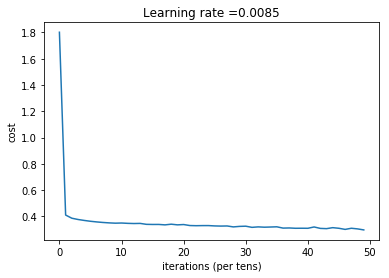

In [21]:
parameters = L_layer_model(X_train.T, y_train.T, layers_dims = layers_dims, learning_rate = 0.0085,num_iterations = 5000, print_cost=True)

In [22]:
predictions_train = predict(X_train.T, y_train.T, parameters)

Accuracy: 0.8808988764044945


In [61]:
# Example 3
# data_banknote_authentication

data = np.loadtxt('./dataset2/data_banknote_authentication.txt', delimiter=',',)

x = data[:,:-1]
y = data[:,-1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1)

m_train = len(x_train)
m_test = len(x_test)
num_n = x_train.shape[1]
numtest_n = x_test.shape[1]

y_train = y_train.reshape(m_train,1)
y_test = y_test.reshape(m_test,1)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("number of features of each example: num_n = " + str(num_n))
print("shape of x_train:",x_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of x_test:",x_test.shape)
print("shape of y_test:",y_test.shape)

Number of training examples: m_train = 1234
Number of testing examples: m_test = 138
number of features of each example: num_n = 4
shape of x_train: (1234, 4)
shape of y_train: (1234, 1)
shape of x_test: (138, 4)
shape of y_test: (138, 1)


In [63]:
layers_dims = [x_train.shape[1], 100, 50, 25, 10, 1]
print(layers_dims)

[4, 100, 50, 25, 10, 1]


Cost after iteration 0: 1.146319
Cost after iteration 100: 0.125043
Cost after iteration 200: 0.055611
Cost after iteration 300: 0.034505
Cost after iteration 400: 0.024235
Cost after iteration 500: 0.018424
Cost after iteration 600: 0.014797
Cost after iteration 700: 0.012298
Cost after iteration 800: 0.010507
Cost after iteration 900: 0.009136
Cost after iteration 1000: 0.008054
Cost after iteration 1100: 0.007183
Cost after iteration 1200: 0.006462
Cost after iteration 1300: 0.005905
Cost after iteration 1400: 0.005446
Cost after iteration 1500: 0.005056
Cost after iteration 1600: 0.004709
Cost after iteration 1700: 0.004379
Cost after iteration 1800: 0.004094
Cost after iteration 1900: 0.003847


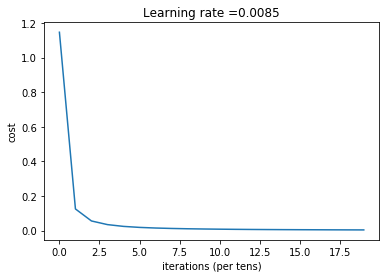

In [66]:
parameters = L_layer_model(x_train.T, y_train.T, layers_dims = layers_dims, learning_rate = 0.0085,num_iterations = 2000, print_cost=True)

In [67]:
predictions_train = predict(x_train.T, y_train.T, parameters)

Accuracy: 0.9999999999999998


In [68]:
predictions_train = predict(x_test.T, y_test.T, parameters)

Accuracy: 1.0
